In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import List


In [20]:
# get the data
filename = 'dataset/emotions_dataset.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df = pd.read_csv(filename, na_filter=False)
df_train = df[(df.usage == 'Training') | (df.usage == 'PublicTest')].copy()
del df
df_train['labels'] = [label_map[e] for e in df_train.emotion]
df_train.head(10)

,emotion,pixels,usage,labels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Anger
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Anger
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,Fear
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training,Sad
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training,Happy
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training,Happy
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training,Fear


In [21]:
def pixels_to_images(pixels_series: pd.Series) -> np.ndarray:
    pixels_lists = [[int(n) for n in p.split()] for p in pixels_series]
    X = np.array(pixels_lists)
    X = X.reshape(-1, 48, 48, 1) / 255
    return X

In [22]:
load_from_disk = False
if load_from_disk:
    with open('dataset/numpy_images.npy', 'rb') as f:
        X = np.load(f)
else:
    X = pixels_to_images(df_train.pixels)
    with open('dataset/numpy_images.npy', 'wb') as f:
        np.save(f, X)
    
print(X.shape)

(32298, 48, 48, 1)


In [29]:
Y_labels = df_train.labels.to_list()
Y = df_train.emotion.astype(int)

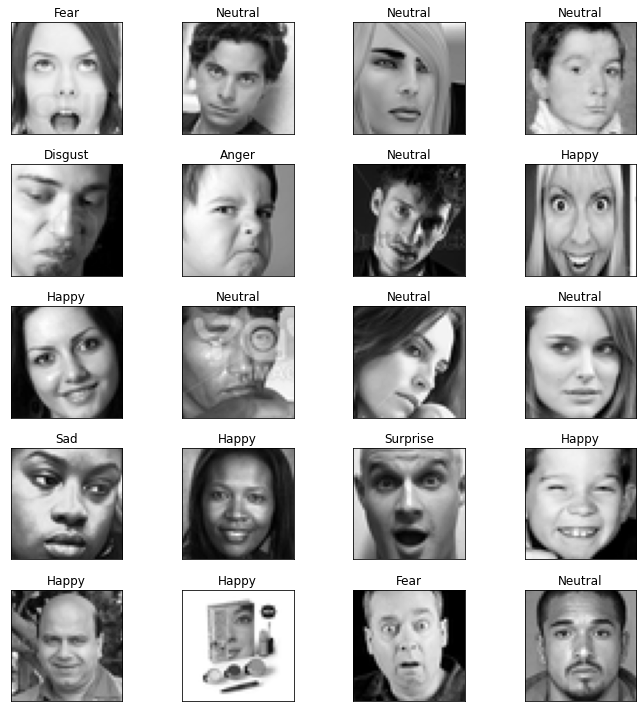

In [25]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X.shape[0])
    img = X[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    true_labels.append(Y_labels[img_id])
    preds.append(true_labels[i-1])
    plt.title(f"{true_labels[i-1]}")
fig.tight_layout()
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [32]:
X_train.shape

(29068, 48, 48, 1)

In [35]:
y_train[:3]

14276    6
21512    0
8793     3
Name: emotion, dtype: int64

In [41]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
    
    return model
model=my_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 128)      

In [ ]:
path_model='checkpoints/model_checkpoint.h5'

h = model.fit(
    x=X_train,     
    y=y_train, 
    batch_size=64, 
    epochs=20, 
    verbose=1, 
    validation_data=(X_test,y_test),
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
    ]
)

In [ ]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

In [ ]:
def emotion_analysis(emotions):
    y_pos = np.arange(len(label_map))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, label_map)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

In [ ]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

**Real Time Expression Prediction**

In [ ]:
from skimage import io
img = image.load_img('../input/myimage/Shawon.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/myimage/Shawon.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

In [ ]:
from skimage import io
img = image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)